In [38]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import exiftool
import pandas as pd

https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Tutorial%201.html
https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Setup.html
https://github.com/micasense/imageprocessing/blob/master/micasense/utils.py

## Raw to Radiance

In [2]:
os.chdir('/mnt/c/DATA/PhG/MicaSense/000/')

In [3]:
my_file = 'IMG_0002_3.tif'

In [4]:
def read_image(file):
    files = [file]
    with exiftool.ExifTool() as et:
        metadata = et.get_metadata_batch(files)
    meta = metadata[0]
    imageRaw = cv2.imread(files[0], -1)
    return (imageRaw, meta)    

In [5]:
def vignette_map(meta):
    # get vignette center
    xVignette = float(meta['XMP:VignettingCenter'][0])
    yVignette = float(meta['XMP:VignettingCenter'][1])

    # get vignette polynomial
    vignettePolyList = [float(i) for i in meta['XMP:VignettingPolynomial']]

    # reverse list and append 1., so that we can call with numpy polyval
    vignettePolyList.reverse()
    vignettePolyList.append(1.)
    vignettePoly = np.array(vignettePolyList)

    # perform vignette correction
    # get coordinate grid across image
    xDim, yDim = meta['EXIF:ImageWidth'],meta['EXIF:ImageHeight']
    x, y = np.meshgrid(np.arange(xDim), np.arange(yDim))

    # meshgrid returns transposed arrays
#     x = x.T
#     y = y.T

    # compute matrix of distances from image center
    r = np.hypot((x - xVignette), (y - yVignette))

    # compute the vignette polynomial for each distance - we divide by the polynomial so that the
    # corrected image is image_corrected = image_original * vignetteCorrection
    vignette = 1. / np.polyval(vignettePoly, r)
    return vignette, x, y

In [6]:
def raw_to_radiance(imageRaw, meta):
    
    # First, we get the darkPixel values.
    blackLevel = meta['EXIF:BlackLevel']
    blackLevel = np.array([int(item) for item in blackLevel.split(' ')])
    darkLevel = blackLevel.mean()
    
    # Get the imager-specific calibrations
    a1, a2, a3 = [float(i) for i in meta['XMP:RadiometricCalibration']]
    
    # Get the parameters of the optical chain (vignette) effects and create a vignette map
    V, x, y = vignette_map(meta)
    
    #we get the exposure and gain settings (gain is represented in the photographic parameter ISO, with a base ISO of 100, so we divide the result to get a numeric gain)    
    exposureTime = float(meta['EXIF:ExposureTime'])
    gain = float(meta['EXIF:ISOSpeed'])/100.0
    
    # Calculate the imager-specfic radiometric correction function, which help to account for the radiometric inaccuracies of the CMOS imager pixels
    R = 1.0 / (1.0 + a2 * y / exposureTime - a3 * y)
    #subtract the dark level and adjust for vignette and row gradient
    L = V * R * (imageRaw - darkLevel)
    
    # apply the radiometric calibration - 
    # scale by the gain-exposure product and multiply with the radiometric calibration coefficient
    bitsPerPixel = meta['EXIF:BitsPerSample']
    dnMax = float(2**bitsPerPixel)
    radianceImage = L.astype(float)/(gain * exposureTime)*a1/dnMax
    return (radianceImage)

In [7]:
my_image,  my_meta = read_image(my_file)

In [8]:
my_calibrated_image = raw_to_radiance(my_image, my_meta)

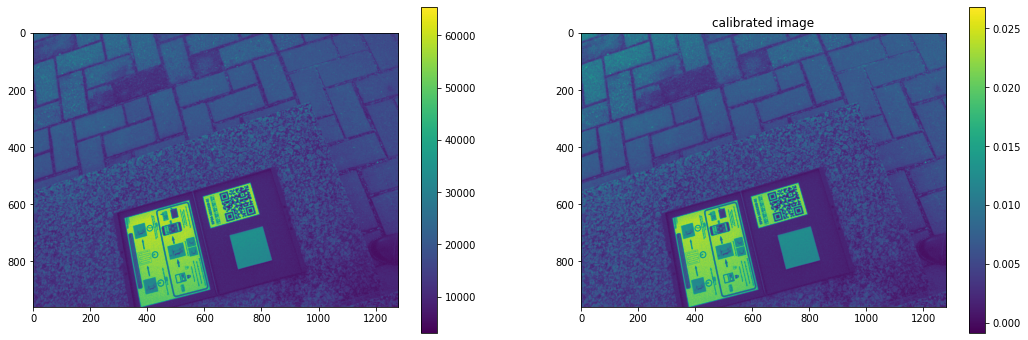

In [9]:
plt.figure(figsize = (18,6))
plt.title('raw image')
plt.subplot(1,2,1)
plt.imshow(my_image)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('calibrated image')
plt.imshow(my_calibrated_image)
plt.colorbar()

## Read Metadata

In [10]:
my_image,  my_meta = read_image(my_file)

In [15]:
my_meta['XMP:WavelengthFWHM'], my_meta['XMP:BandName']

10

In [46]:
print('Channel\t\t{} \nWavelength\t{}\nBandHalfWidth\t{}'.format(my_meta['XMP:BandName'],
                                                           my_meta['XMP:CentralWavelength'],
                                                           my_meta['XMP:WavelengthFWHM']))

Channel		Red 
Wavelength	668
BandHalfWidth	10


In [47]:
channel_min = my_meta['XMP:CentralWavelength'] - my_meta['XMP:WavelengthFWHM']/2
channel_max = my_meta['XMP:CentralWavelength'] + my_meta['XMP:WavelengthFWHM']/2

## Radiance to Reflectance

In [42]:
#read panel reflectance
panel_reflectance = pd.read_csv('/mnt/c/DATA/PhG/Micasense/RP04-1826268-SC.csv', names = ['nm', 'refl'])

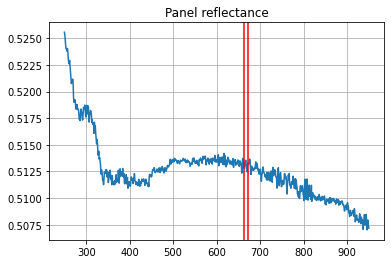

In [51]:
plt.title('Panel reflectance')
plt.plot(panel_reflectance.nm, panel_reflectance.refl)
plt.axvline(channel_min, color = 'red')
plt.axvline(channel_max, color = 'red')
plt.grid()

In [77]:
panelReflectance = panel_reflectance.loc[(panel_reflectance.nm>=channel_min)&(panel_reflectance.nm<=channel_max)].refl.mean()

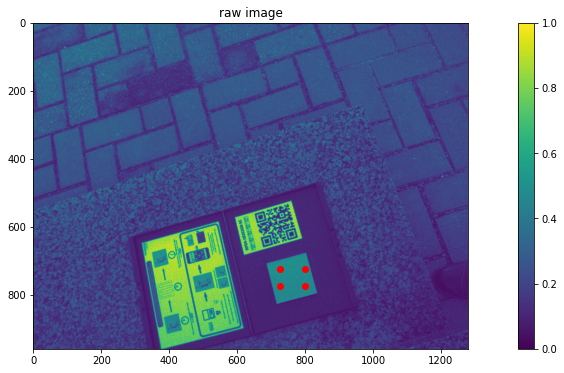

In [91]:
plt.figure(figsize = (18,6))
plt.title('raw image')
plt.imshow(my_image)
plt.scatter(725, 725, color = 'red')
plt.scatter(800, 725, color = 'red')
plt.scatter(800, 775, color = 'red')
plt.scatter(725, 775, color = 'red')
plt.colorbar()

In [80]:
panelRegion = my_calibrated_image[725:775, 725:800]
meanRadiance = panelRegion.mean()
print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))

Mean Radiance in panel region: 0.012 W/m^2/nm/sr


In [84]:
radianceToReflectance = panelReflectance / meanRadiance
print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance))

Radiance to reflectance conversion factor: 42.001


In [87]:
reflectanceImage = my_image * radianceToReflectance

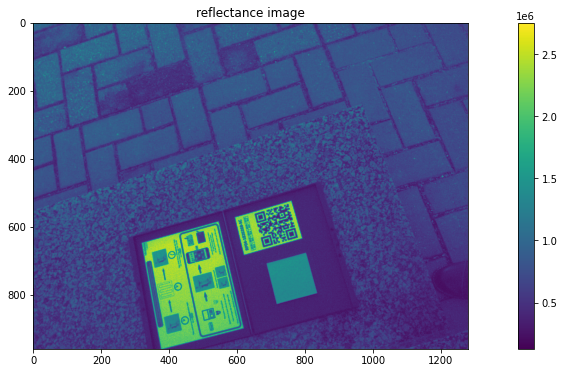

In [90]:
plt.figure(figsize = (18,6))
plt.title('reflectance image')
plt.imshow(reflectanceImage)
plt.colorbar()

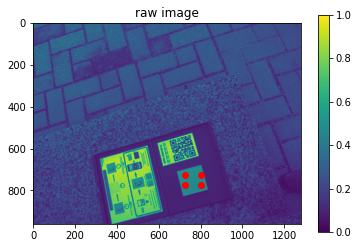

In [93]:
def get_reflectance_factor(paneImage, metaData, panelRectangle = [725,775, 725,800],
                            panel_reflectance_file = '/mnt/c/DATA/PhG/Micasense/RP04-1826268-SC.csv'):
    print('Channel\t\t{} \nWavelength\t{}\nBandHalfWidth\t{}'.format(metaData['XMP:BandName'],
                                                                     metaData['XMP:CentralWavelength'],
                                                                     metaData['XMP:WavelengthFWHM']))
    
    channel_min = my_meta['XMP:CentralWavelength'] - my_meta['XMP:WavelengthFWHM']/2
    channel_max = my_meta['XMP:CentralWavelength'] + my_meta['XMP:WavelengthFWHM']/2
    panelReflectance = panel_reflectance.loc[(panel_reflectance.nm>=channel_min)&(panel_reflectance.nm<=channel_max)].refl.mean()
    
    plt.figure(figsize = (18,6))
plt.title('raw image')
plt.imshow(my_image)
plt.scatter(725, 725, color = 'red')
plt.scatter(800, 725, color = 'red')
plt.scatter(800, 775, color = 'red')
plt.scatter(725, 775, color = 'red')
plt.colorbar()
    

In [ ]:
rgb_stack = np.stack((red//2**8, green//2**8,  blue//2**8), axis = 2)
plt.figure(figsize=(25, 10))
plt.imshow(rgb_stack)
plt.show()